<a href="https://colab.research.google.com/github/danielsadoc/RL_jack_car_rental/blob/main/blackwell_jack_rental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jack's Car Rental — Discounted vs Average Reward (Blackwell Optimality)

This notebook illustrates the **Blackwell optimality theorem** through the Jack’s Car Rental MDP:

- Solve **average-reward MDP** via occupancy measure LP
- Solve **discounted MDP** for several \( \gamma \uparrow 1 \)
- Compare optimal policies \( \pi^*_{\gamma} \) and \( \pi^{\text{avg}} \)
- Identify empirical Blackwell region.

In [1]:
import math
import numpy as np
from itertools import product
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## 1. Problem parameters and state space

In [2]:
MAX_CARS = 20
A_MAX_MOVE = 5
ACTIONS_ALL = np.arange(-A_MAX_MOVE, A_MAX_MOVE+1)

LAMBDA_X1, LAMBDA_Y1 = 3.0, 3.0
LAMBDA_X2, LAMBDA_Y2 = 4.0, 2.0
RENT_REWARD = 10.0
MOVE_COST = 2.0

STATES = [(n1, n2) for n1 in range(MAX_CARS+1) for n2 in range(MAX_CARS+1)]
S_index = {s: i for i, s in enumerate(STATES)}
NUM_STATES = len(STATES)

## 2. Feasible actions and Poisson helpers

In [3]:
def feasible_actions(n1, n2):
    feas = []
    for a in ACTIONS_ALL:
        if a >= 0:
            if n1 >= a and n2 + a <= MAX_CARS:
                feas.append(a)
        else:
            if n2 >= -a and n1 - a <= MAX_CARS:
                feas.append(a)
    return feas

FEAS_ACTIONS = [feasible_actions(n1, n2) for (n1, n2) in STATES]

def poisson_pmf(lam, k):
    if k < 0:
        return 0.0
    return math.exp(-lam) * (lam**k) / math.factorial(k)

def poisson_cdf(lam, k):
    return sum(poisson_pmf(lam, i) for i in range(k+1))

def poisson_tail_prob(lam, k):
    if k <= 0:
        return 1.0
    return 1.0 - poisson_cdf(lam, k-1)

## 3. Transition and reward model

In [4]:
RENTAL_CACHE = {}
NEXTCOUNT_CACHE = {}

def rental_probabilities(c, lam_x):
    probs = np.zeros(c+1)
    if c == 0:
        probs[0] = 1.0
        return probs
    for r in range(c):
        probs[r] = poisson_pmf(lam_x, r)
    probs[c] = poisson_tail_prob(lam_x, c)
    return probs / probs.sum()

def next_count_distribution_given_rentals(c, r, lam_y):
    remaining = c - r
    probs = np.zeros(MAX_CARS+1)
    for nprime in range(MAX_CARS):
        y = nprime - remaining
        if y >= 0:
            probs[nprime] = poisson_pmf(lam_y, y)
    tail_needed = MAX_CARS - remaining
    probs[MAX_CARS] = poisson_tail_prob(lam_y, max(tail_needed, 0))
    return probs / probs.sum()

def get_rental_probs(c, lam_x):
    key = (c, lam_x)
    if key not in RENTAL_CACHE:
        RENTAL_CACHE[key] = rental_probabilities(c, lam_x)
    return RENTAL_CACHE[key]

def get_nextcount_probs(c, r, lam_y):
    key = (c, r, lam_y)
    if key not in NEXTCOUNT_CACHE:
        NEXTCOUNT_CACHE[key] = next_count_distribution_given_rentals(c, r, lam_y)
    return NEXTCOUNT_CACHE[key]

def post_move_counts(n1, n2, a):
    c1 = n1 - a
    c2 = n2 + a
    return c1, c2

def expected_rentals_for_lot(c, lam_x):
    probs = get_rental_probs(c, lam_x)
    support = np.arange(len(probs))
    return (support * probs).sum()

def transition_and_reward_for_state_action(n1, n2, a):
    c1, c2 = post_move_counts(n1, n2, a)
    e_r1 = expected_rentals_for_lot(c1, LAMBDA_X1)
    e_r2 = expected_rentals_for_lot(c2, LAMBDA_X2)
    reward = RENT_REWARD * (e_r1 + e_r2) - MOVE_COST * abs(a)
    r1_probs = get_rental_probs(c1, LAMBDA_X1)
    r2_probs = get_rental_probs(c2, LAMBDA_X2)
    n1prime_given_r1 = [get_nextcount_probs(c1, r1, LAMBDA_Y1) for r1 in range(c1+1)]
    n2prime_given_r2 = [get_nextcount_probs(c2, r2, LAMBDA_Y2) for r2 in range(c2+1)]
    P_row = np.zeros(NUM_STATES)
    for r1 in range(c1+1):
        for r2 in range(c2+1):
            p_r = r1_probs[r1] * r2_probs[r2]
            joint = np.outer(n1prime_given_r1[r1], n2prime_given_r2[r2]) * p_r
            for n1p in range(MAX_CARS+1):
                base = n1p * (MAX_CARS+1)
                P_row[base:base + (MAX_CARS+1)] += joint[n1p, :]
    return P_row, reward

## 4. Average-reward LP (occupancy measures)

Optimal average reward per day: 49.5703


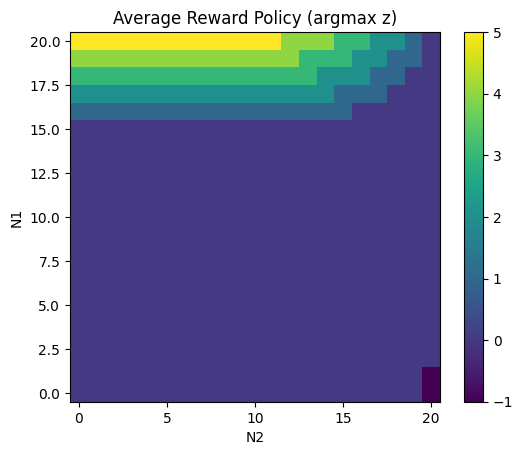

In [5]:
pairs = []
R_vec = []
P_dense_rows = []

for s_idx, (n1, n2) in enumerate(STATES):
    for a in FEAS_ACTIONS[s_idx]:
        P_row, R_sa = transition_and_reward_for_state_action(n1, n2, a)
        pairs.append((s_idx, a))
        R_vec.append(R_sa)
        P_dense_rows.append(P_row)

K = len(pairs)
R_vec = np.array(R_vec)
P_dense = np.vstack(P_dense_rows)

A_eq = np.zeros((NUM_STATES+1, K))
b_eq = np.zeros(NUM_STATES+1)
for k, (s_idx, a) in enumerate(pairs):
    A_eq[s_idx, k] += 1.0
    A_eq[:NUM_STATES, k] -= P_dense[k, :]
A_eq[NUM_STATES, :] = 1.0
b_eq[NUM_STATES] = 1.0

res = linprog(-R_vec, A_eq=A_eq, b_eq=b_eq, bounds=[(0,None)]*K, method='highs')
z = res.x
avg_reward = R_vec @ z
print(f"Optimal average reward per day: {avg_reward:.4f}")

pi = {s_idx: {} for s_idx in range(NUM_STATES)}
z_state = np.zeros(NUM_STATES)
for k, (s_idx, a) in enumerate(pairs):
    pi[s_idx][a] = z[k]
    z_state[s_idx] += z[k]
avg_policy_actions = np.zeros(NUM_STATES, dtype=int)
for s_idx in range(NUM_STATES):
    if z_state[s_idx] > 0:
        avg_policy_actions[s_idx] = max(pi[s_idx].items(), key=lambda kv: kv[1])[0]
    else:
        feas = FEAS_ACTIONS[s_idx]
        avg_policy_actions[s_idx] = min(feas, key=abs) if feas else 0

plt.imshow(avg_policy_actions.reshape((MAX_CARS+1, MAX_CARS+1)), origin='lower')
plt.title('Average Reward Policy (argmax z)')
plt.xlabel('N2'); plt.ylabel('N1'); plt.colorbar(); plt.show()

## 5. Discounted LP for a ladder of $\gamma$ values

In [6]:
def solve_discounted_lp_and_policy(gamma):
    A = np.zeros((K, NUM_STATES))
    b = np.zeros(K)
    for k, (s_idx, a) in enumerate(pairs):
        A[k, :] = gamma * P_dense[k, :]
        A[k, s_idx] -= 1.0
        b[k] = -R_vec[k]
    res = linprog(np.ones(NUM_STATES), A_ub=A, b_ub=b, bounds=[(None,None)]*NUM_STATES, method='highs')
    v = res.x
    policy = np.zeros(NUM_STATES, dtype=int)
    for s_idx, (n1, n2) in enumerate(STATES):
        best_q, best_a = -1e300, 0
        for a in FEAS_ACTIONS[s_idx]:
            k = next(k for k,(ss,aa) in enumerate(pairs) if ss==s_idx and aa==a)
            q = R_vec[k] + gamma * (P_dense[k,:] @ v)
            if q > best_q:
                best_q, best_a = q, a
        policy[s_idx] = best_a
    return policy

gammas = [0.95, 0.97, 0.98, 0.99, 0.995, 0.997, 0.999]
policies_disc = {g: solve_discounted_lp_and_policy(g) for g in gammas}
rates = {g: np.mean(policies_disc[g]==avg_policy_actions) for g in gammas}
for g in gammas:
    print(f"γ={g}: match rate = {rates[g]*100:.1f}%")

γ=0.95: match rate = 65.3%
γ=0.97: match rate = 75.7%
γ=0.98: match rate = 80.7%
γ=0.99: match rate = 86.6%
γ=0.995: match rate = 92.5%
γ=0.997: match rate = 96.4%
γ=0.999: match rate = 100.0%


## 6. Visualization of Blackwell phenomenon

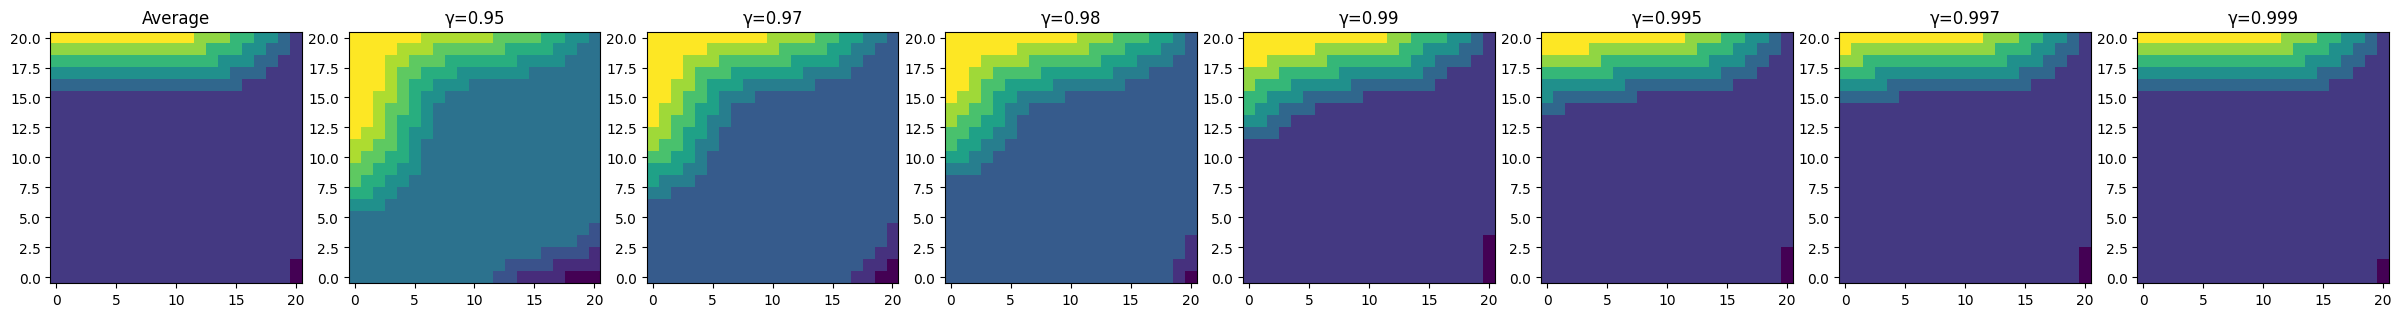

In [7]:
cols = len(gammas)+1
plt.figure(figsize=(3*cols,5))
ax = plt.subplot(1,cols,1)
ax.imshow(avg_policy_actions.reshape((MAX_CARS+1, MAX_CARS+1)), origin='lower')
ax.set_title('Average')

for j,g in enumerate(gammas, start=2):
    ax = plt.subplot(1,cols,j)
    ax.imshow(policies_disc[g].reshape((MAX_CARS+1, MAX_CARS+1)), origin='lower')
    ax.set_title(f"γ={g}")
plt.tight_layout(); plt.show()